In [1]:
import pydicom
import os,re
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import SimpleITK as sitk
from IPython.display import clear_output
import math
import sys
sys.path.append(r'F:\tensorflow\LiChen\iCafe')  
from iCafePython import iCafe

Branch length not loaded


In [2]:
p=256 #for dicom scaling
ESP=0.1 #for dicom scaling

def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    plt.figure()
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

def save_transform_and_image(transform, fixed_image, moving_image, fixed_ori,moving_ori, dicompath, outputfile_prefix,multi_tp):
    global cnt_global                       
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)    
    resample.SetInterpolator(sitk.sitkBSpline)  
    resample.SetTransform(transform)
    #sitk.WriteImage(resample.Execute(moving_image), outputfile_prefix+'.mha')
    #sitk.WriteTransform(transform, outputfile_prefix+'.tfm')
    max_moving = 0
    min_moving = 0
    exqimg = sitk.GetArrayFromImage(resample.Execute(moving_image))
    print(exqimg.shape)
    fix_imgs =  sitk.GetArrayFromImage(fixed_image)
    for i in range(0,exqimg.shape[0]):
        max_moving = max(max_moving,np.amax(exqimg[i,:,:]))
        min_moving = min(min_moving,np.amin(exqimg[i,:,:]))
        head1,tail1 = os.path.split(fixed_ori[0])
        head2,tail2 = os.path.split(moving_ori[0])
        
        #if ('S101' in tail1) and ('S104' in tail2):
         #   Aname = Adomainpath + str(cnt_global)+'.png'
          #  Bname = Bdomainpath + str(cnt_global)+'.png'
           # plt.imsave(Aname, fix_imgs[i,:,:],cmap = plt.get_cmap('gray'))
            #plt.imsave(Bname, exqimg[i,:,:],cmap = plt.get_cmap('gray'))
            #cnt_global += 1
            #print(Aname)
        
    if multi_tp == False:

        ds_ori = pydicom.dcmread(fixed_ori[0])
        ds_ori_end = pydicom.dcmread(fixed_ori[-1])
        sp_x = (ds_ori_end[0x20,0x32].value[0]-ds_ori[0x20,0x32].value[0])/len(fixed_ori)
        sp_y = (ds_ori_end[0x20,0x32].value[1]-ds_ori[0x20,0x32].value[1])/len(fixed_ori)
        sp_z = (ds_ori_end[0x20,0x32].value[2]-ds_ori[0x20,0x32].value[2])/len(fixed_ori)
        a =  ds_ori_end.SliceLocation-float(ds_ori_end[0x20,0x32].value[0])
        b =  ds_ori_end.SliceLocation-float(ds_ori_end[0x20,0x32].value[1])
        c =  ds_ori_end.SliceLocation-float(ds_ori_end[0x20,0x32].value[2])
        spori = -math.sqrt(sp_x*sp_x+sp_y*sp_y+sp_z*sp_z)
        slicelocation_axis = 'x'
        if min(a,b,c)==b:
            slicelocation_axis = 'y'
        elif min(a,b,c)==c:
            slicelocation_axis = 'z'

        if len(moving_ori)<len(fixed_ori):
            reg_img = resample.Execute(moving_image)
            #reg_img_resample = zoom(reg_img, (1, 1, len(moving_ori)/len(fixed_ori)))

            new_x_size = (reg_img.GetSize())[0] 
            new_y_size = (reg_img.GetSize())[1]
            new_z_size = len(moving_ori) #downsample
            new_size = [new_x_size, new_y_size, new_z_size]
            new_spacing = [old_sz*old_spc/new_sz  for old_sz, old_spc, new_sz in zip(reg_img.GetSize(), reg_img.GetSpacing(), new_size)]
            interpolator_type = sitk.sitkLinear

            reg_img_resample = sitk.Resample(reg_img, new_size, sitk.Transform(),\
                                             interpolator_type, reg_img.GetOrigin(),\
                                             new_spacing, reg_img.GetDirection(), 0.0, reg_img.GetPixelIDValue())
            
            new_reg_img_resample = (reg_img_resample-min_moving)/(max_moving-min_moving)*p

            for i in range(0,len(moving_ori)): 
                path = moving_ori[i]
                ds = pydicom.dcmread(path)
                head,tail = os.path.split(path) 
                #new_data = ds.pixel_array
                new_data = sitk.GetArrayFromImage(new_reg_img_resample[:,:,i])
                #new_data = (new_data-np.amin(new_data))/(np.amax(new_data)-np.amin(new_data)+ESP)*p
                new_data[new_data<0]=0
                new_data[new_data>p]=p
                new_data = (new_data).astype('int16')
                sp = -(spori)*(len(fixed_ori)/len(moving_ori))
                xsp = (sp_x)*(len(fixed_ori)/len(moving_ori))
                ysp = (sp_y)*(len(fixed_ori)/len(moving_ori))
                zsp = (sp_z)*(len(fixed_ori)/len(moving_ori))
                #print((float(ds_ori[0x18,0x88].value)),len(fixed_ori),len(moving_ori),sp)
                ds[0x18,0x88].value = sp

                ds[0x20,0x37].value = ds_ori[0x20,0x37].value
                if slicelocation_axis == 'x':
                    ds.SliceLocation = ds_ori.SliceLocation+xsp*i
                elif slicelocation_axis == 'y':
                    ds.SliceLocation = ds_ori.SliceLocation+ysp*i
                elif slicelocation_axis == 'z':
                    ds.SliceLocation = ds_ori.SliceLocation+zsp*i
                orientation = [ds_ori[0x20,0x32].value[0]+xsp*i,\
                                ds_ori[0x20,0x32].value[1]+ysp*i,ds_ori[0x20,0x32].value[2]+zsp*i]
                ds[0x20,0x32].value =  orientation
                ds[0x28,0x10].value = ds_ori[0x28,0x10].value
                ds[0x28,0x11].value = ds_ori[0x28,0x11].value
                ds[0x28,0x30].value = ds_ori[0x28,0x30].value
                ds.PixelData = new_data.tostring()
                newpath = dicompath+ tail
                ds.save_as(newpath)
                print(newpath)

        elif len(moving_ori)>=len(fixed_ori):    
            for i in range(0,len(moving_ori)): 
                path = moving_ori[i]
                ds = pydicom.dcmread(path)
                head,tail = os.path.split(path)
                reg_img = resample.Execute(moving_image)
                
                new_reg_img = (reg_img-min_moving)/(max_moving-min_moving)*p
                #new_reg_img = reg_img
                if i < len(fixed_ori):
                    ds_ori = pydicom.dcmread(fixed_ori[i])
                    #new_data = ds.pixel_array
                    new_data = sitk.GetArrayFromImage(new_reg_img[:,:,i])
                    #new_data = (new_data-np.amin(new_data))/(np.amax(new_data)-np.amin(new_data)+ESP)*p
                    new_data[new_data<0]=0
                    new_data[new_data>p]=p
                    new_data = (new_data).astype('int16')
                    ds[0x20,0x32].value = ds_ori[0x20,0x32].value
                    ds[0x20,0x37].value = ds_ori[0x20,0x37].value
                    ds.SliceLocation = ds_ori.SliceLocation
                    ds[0x28,0x10].value = ds_ori[0x28,0x10].value
                    ds[0x28,0x11].value = ds_ori[0x28,0x11].value
                    ds[0x28,0x30].value = ds_ori[0x28,0x30].value
                    ds.PixelData = new_data.tostring()
                    newpath = dicompath+ tail
                    ds.save_as(newpath)
                    print(newpath)
                else:
                    ds_ori = pydicom.dcmread(fixed_ori[-1])
                    new_data = np.zeros((ds_ori.Rows,ds_ori.Columns))            
                    new_data = (new_data).astype('int16')
                    sp = -(float(ds_ori[0x18,0x88].value))
                    xsp = (sp_x)*(len(fixed_ori)/len(moving_ori))
                    ysp = (sp_y)*(len(fixed_ori)/len(moving_ori))
                    zsp = (sp_z)*(len(fixed_ori)/len(moving_ori))
                    orientation = [ds_ori[0x20,0x32].value[0]+xsp*(i-len(fixed_ori)),\
                                   ds_ori[0x20,0x32].value[1]+ysp*(i-len(fixed_ori))\
                                   ,ds_ori[0x20,0x32].value[2]+zsp*(i-len(fixed_ori))]
                    ds[0x20,0x32].value =  orientation


                    ds[0x20,0x37].value = ds_ori[0x20,0x37].value
                    if slicelocation_axis == 'x':
                        ds.SliceLocation = ds_ori.SliceLocation+xsp*(i-len(fixed_ori))
                    elif slicelocation_axis == 'y':
                        ds.SliceLocation = ds_ori.SliceLocation+ysp*(i-len(fixed_ori))
                    elif slicelocation_axis == 'z':
                        ds.SliceLocation = ds_ori.SliceLocation+zsp*(i-len(fixed_ori))
                    #ds.SliceLocation = ds_ori.SliceLocation+sp*(i-len(fixed_ori))
                    ds[0x28,0x30].value = ds_ori[0x28,0x30].value
                    ds.Rows = ds_ori.Rows
                    ds.Columns = ds_ori.Columns
                    ds.PixelData = new_data.tostring()
                    newpath = dicompath+ tail
                    ds.save_as(newpath)
                    print(newpath)


           # ds = pydicom.dcmread(newpath)
           # img = ds.pixel_array
           # plt.figure()
           # plt.imshow(img)
           # plt.show()
           # plt.close()
    else:
        reg_img = resample.Execute(moving_image)
        new_reg_img = (reg_img-min_moving)/(max_moving-min_moving)*p
        for i in range(0,len(moving_ori)): 
            path = moving_ori[i]
            ds = pydicom.dcmread(path)
            head,tail = os.path.split(path)
            ds_ori = pydicom.dcmread(fixed_ori[i])
            #new_data = ds.pixel_array
            new_data = sitk.GetArrayFromImage((new_reg_img)[:,:,i])
            #new_data = (new_data-np.amin(new_data))/(np.amax(new_data)-np.amin(new_data)+ESP)*p
            new_data[new_data<0]=0
            new_data[new_data>p]=p
            new_data = (new_data).astype('int16')
            ds[0x20,0x32].value = ds_ori[0x20,0x32].value
            ds[0x20,0x37].value = ds_ori[0x20,0x37].value
            ds.SliceLocation = ds_ori.SliceLocation
            ds[0x28,0x10].value = ds_ori[0x28,0x10].value
            ds[0x28,0x11].value = ds_ori[0x28,0x11].value
            ds[0x28,0x30].value = ds_ori[0x28,0x30].value
            ds.PixelData = new_data.tostring()
            newpath = dicompath+ tail
            ds.save_as(newpath)
            print(newpath)


# Callback we associate with the StartEvent, sets up our new data.
def metric_start_plot():
    global metric_values, multires_iterations
    global current_iteration_number
    
    metric_values = []
    multires_iterations = []
    current_iteration_number = -1

# Callback we associate with the EndEvent, do cleanup of data and figure.
def metric_end_plot():
    global metric_values, multires_iterations
    global current_iteration_number

    del metric_values
    del multires_iterations
    del current_iteration_number
    # Close figure, we don't want to get a duplicate of the plot latter on
    plt.close()

# Callback we associate with the IterationEvent, update our data and display 
# new figure.    
def metric_plot_values(registration_method):
    global metric_values, multires_iterations
    global current_iteration_number
    
    # Some optimizers report an iteration event for function evaluations and not
    # a complete iteration, we only want to update every iteration.
    if registration_method.GetOptimizerIteration() == current_iteration_number:
        return

    current_iteration_number =  registration_method.GetOptimizerIteration()
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot 
    # current data.
    clear_output(wait=True)
    # Plot the similarity metric values.
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback we associate with the MultiResolutionIterationEvent, update the 
# index into the metric_values list. 
def metric_update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))        

def sortdir(flist):
    for file in flist:
        if ('.dcm') not in file:
            del flist[flist.index(file)]
        for j in range(0,len(flist)):
            for k in range(j+1,len(flist)):
                num=int(re.split('E|S|I|.dcm',flist[j])[3])
                num2=int(re.split('E|S|I|.dcm',flist[k])[3])
                if num>num2:
                    tmp=flist[j]
                    flist[j]=flist[k]
                    flist[k]=tmp
    return flist

print('Functions successfully defined.')

Functions successfully defined.


In [3]:
root = r'Y:\trials\realmbl1y2y\images\Org_Images/'
split_seq_path = 'split_seq_REALM_MPR/'

if not os.path.exists(split_seq_path):
    os.mkdir(split_seq_path)

outputpath = "output_MPR/"
if not os.path.exists(outputpath):
    os.mkdir(outputpath)
    
icafepath = r"E:\iCafe\result\RealmReg2020/"
icafedatapath = r"E:\iCafe\data\RealmReg2020/"

caselist = os.listdir(root)
if '.DS_Store' in caselist:
    del caselist[caselist.index('.DS_Store')]

print(caselist)

['P10', 'P104', 'P109', 'P114', 'P123', 'P124', 'P140', 'P144', 'P158', 'P159-P697', 'P164', 'P174', 'P178', 'P184', 'P185', 'P209', 'P21', 'P222', 'P232', 'P24', 'P247-P625', 'P25', 'P254-P240', 'P254-P872', 'P261-P624', 'P265', 'P27', 'P271', 'P277', 'P281', 'P290', 'P294', 'P30', 'P301-P913', 'P311', 'P318', 'P322', 'P325', 'P33', 'P331', 'P337', 'P34', 'P340', 'P343', 'P348', 'P351', 'P353', 'P372', 'P379', 'P399', 'P410', 'P412', 'P42', 'P428', 'P431', 'P440-P666', 'P445', 'P463', 'P468', 'P478', 'P486', 'P491', 'P492', 'P516-421', 'P516-P71', 'P535', 'P545', 'P553', 'P557', 'P561', 'P566', 'P569', 'P596', 'P599', 'P626', 'P632-P196', 'P640', 'P662-P202', 'P680', 'P689', 'P70', 'P704', 'P715-P780', 'P732', 'P738', 'P742', 'P775', 'P790', 'P792', 'P798', 'P806', 'P807', 'P816', 'P817', 'P82', 'P828', 'P834', 'P838', 'P848', 'P858', 'P863', 'P869', 'P882', 'P9', 'P904', 'P916', 'P932', 'P934', 'P950', 'P973', 'P974', 'P978', 'P993', 'P995', 'P997', 'PB12-615']


In [9]:
#metadatafile = 'REALM_for_MPR.xlsx'
metadatafile = 'Book1.xlsx'
import pandas as pd
metadata = pd.read_excel(metadatafile)
info = {}
idbank = {}
for index, row in metadata.iterrows():
    info['P'+str(int(row["Pid"]))]=['E'+str(int(row["BL"])),'E'+str(row["1Y"]),'E'+str(row["2Y"])]
    idbank['P'+str(int(row["Pid"]))] = [str(row["ID"])]
    # info[str(row["Pid"])]=[str(row["BL"]),str(row["1Y"]),str(row["2Y"])]
    # idbank[str(row["Pid"])] = [str(row["ID"])]
print(info)
print(idbank)

{'P9': ['E93705', 'E707', 'E24328'], 'P21': ['E2432', 'E13135', 'E58599'], 'P24': ['E91387', 'E45834', 'E64828'], 'P42': ['E49827', 'E4805', 'E50745'], 'P114': ['E12044', 'E67207', 'E239'], 'P123': ['E61068', 'E47491', 'E60739'], 'P144': ['E67164', 'E48836', 'E41027'], 'P294': ['E66489', 'E73112', 'E63195'], 'P318': ['E80790', 'E50768', 'E12235'], 'P331': ['E17971', 'E3694', 'E62767'], 'P343': ['E72986', 'E35843', 'E60294'], 'P348': ['E51938', 'E32470', 'E11307'], 'P463': ['E19899', 'E82084', 'E50021'], 'P468': ['E7243', 'E87282', 'E14698'], 'P486': ['E19206', 'E31042', 'E99741'], 'P561': ['E69995', 'E99764', 'E78320'], 'P689': ['E98120', 'E59854', 'E81868'], 'P704': ['E8033', 'E20659', 'E81057'], 'P806': ['E28330', 'E97239', 'E98858'], 'P828': ['E93627', 'E68611', 'E86429'], 'P834': ['E56145', 'E57927', 'E22281'], 'P838': ['E2070', 'E86130', 'E26049'], 'P848': ['E3687', 'E83495', 'E6437'], 'P858': ['E22101', 'E69886', 'E67077'], 'P869': ['E18507', 'E88476', 'E80538'], 'P916': ['E96628

In [5]:
# split seqs for a case
for case in caselist:
    #if case != c: continue
    if case not in info:
        continue
        
    casepath = root+case+'/'
    pre_casepath = split_seq_path + case + '/'
    caseoutputpath = outputpath + case + '/'
    
    if not os.path.exists(caseoutputpath):
        os.mkdir(caseoutputpath)
        print('Mkdir:',caseoutputpath)
    if not os.path.exists(pre_casepath):
        os.mkdir(pre_casepath)
        print('Mkdir:',pre_casepath)
        
    TP_list = info[case]
    
    for t in TP_list:
        output_tppath = caseoutputpath+t+'/'
        if not os.path.exists(output_tppath):
            os.mkdir(output_tppath)
            print('Mkdir:',output_tppath)
    
    seq_list = ['S101','S104','S105','S109']
    # TP_list = ['TP1','TP2','TP3']
    for seq in seq_list:
        seqpath = pre_casepath + seq+'/'
        if not os.path.exists(seqpath):
            os.mkdir(seqpath)
            print('Mkdir:',seqpath)
        for t in TP_list:
            tppath = seqpath + t +'/'
            if not os.path.exists(tppath):
                os.mkdir(tppath)
                print('Mkdir:',tppath)
                
    for i in TP_list:
        print('Processing:',i)
        subcasepath = casepath+i+'/'
        if not os.path.exists(subcasepath):
            os.mkdir(subcasepath)
            print('Mkdir:',subcasepath)
        filelist = os.listdir(subcasepath)
    
        for f in filelist:
            src = subcasepath+f
            print('\rcopying',src,end='')
            for attempt in range(20):
                try:
                    if 'S101' in f and '.dcm' in f:
                        dst = pre_casepath+'S101/'+i+'/'+f
                        if not os.path.exists(dst):
                            shutil.copyfile(src, dst)  

                    elif 'S104' in f and '.dcm' in f:
                        dst = pre_casepath+'S104/'+i+'/'+f
                        if not os.path.exists(dst):
                            shutil.copyfile(src, dst)

                    elif 'S105' in f and '.dcm' in f:
                        dst = pre_casepath+'S105/'+i+'/'+f
                        if not os.path.exists(dst):
                            shutil.copyfile(src, dst)  

                    elif 'S109' in f and '.dcm' in f:
                        dst = pre_casepath+'S109/'+i+'/'+f
                        if not os.path.exists(dst):
                            shutil.copyfile(src, dst)  
                except:
                    print('@@@@Connection loss. Retry!@@@@')
                    continue
                break
            else:
                print('###Tried 20 times, still failed')


Mkdir: output_MPR/P114/
Mkdir: split_seq_REALM_MPR/P114/
Mkdir: output_MPR/P114/E12044/
Mkdir: output_MPR/P114/E67207/
Mkdir: output_MPR/P114/E239/
Mkdir: split_seq_REALM_MPR/P114/S101/
Mkdir: split_seq_REALM_MPR/P114/S101/E12044/
Mkdir: split_seq_REALM_MPR/P114/S101/E67207/
Mkdir: split_seq_REALM_MPR/P114/S101/E239/
Mkdir: split_seq_REALM_MPR/P114/S104/
Mkdir: split_seq_REALM_MPR/P114/S104/E12044/
Mkdir: split_seq_REALM_MPR/P114/S104/E67207/
Mkdir: split_seq_REALM_MPR/P114/S104/E239/
Mkdir: split_seq_REALM_MPR/P114/S105/
Mkdir: split_seq_REALM_MPR/P114/S105/E12044/
Mkdir: split_seq_REALM_MPR/P114/S105/E67207/
Mkdir: split_seq_REALM_MPR/P114/S105/E239/
Mkdir: split_seq_REALM_MPR/P114/S109/
Mkdir: split_seq_REALM_MPR/P114/S109/E12044/
Mkdir: split_seq_REALM_MPR/P114/S109/E67207/
Mkdir: split_seq_REALM_MPR/P114/S109/E239/
Processing: E12044
copying Y:\trials\realmbl1y2y\images\Org_Images/P114/E12044/E12044S109I99.dcmProcessing: E67207l1y2y\images\Org_Images/P114/E12044/E12044S101I117.dcm

copying Y:\trials\realmbl1y2y\images\Org_Images/P144/E67164/E67164S109I99.dcmProcessing: E48836l1y2y\images\Org_Images/P144/E67164/E67164S101I113.dcm Y:\trials\realmbl1y2y\images\Org_Images/P144/E67164/E67164S101I128.dcm Y:\trials\realmbl1y2y\images\Org_Images/P144/E67164/E67164S101I132.dcm Y:\trials\realmbl1y2y\images\Org_Images/P144/E67164/E67164S101I17.dcm Y:\trials\realmbl1y2y\images\Org_Images/P144/E67164/E67164S101I36.dcm Y:\trials\realmbl1y2y\images\Org_Images/P144/E67164/E67164S101I46.dcm Y:\trials\realmbl1y2y\images\Org_Images/P144/E67164/E67164S101I5.dcm Y:\trials\realmbl1y2y\images\Org_Images/P144/E67164/E67164S101I63.dcm Y:\trials\realmbl1y2y\images\Org_Images/P144/E67164/E67164S101I68.dcm Y:\trials\realmbl1y2y\images\Org_Images/P144/E67164/E67164S101I76.dcm Y:\trials\realmbl1y2y\images\Org_Images/P144/E67164/E67164S101I90.dcm Y:\trials\realmbl1y2y\images\Org_Images/P144/E67164/E67164S104I100.dcm Y:\trials\realmbl1y2y\images\Org_Images/P144/E67164/E67164S104I106.dcm Y:\tria

copying Y:\trials\realmbl1y2y\images\Org_Images/P331/E17971/E17971S109I99.dcmProcessing: E3694bl1y2y\images\Org_Images/P331/E17971/E17971S101I102.dcm Y:\trials\realmbl1y2y\images\Org_Images/P331/E17971/E17971S101I108.dcm Y:\trials\realmbl1y2y\images\Org_Images/P331/E17971/E17971S101I112.dcm Y:\trials\realmbl1y2y\images\Org_Images/P331/E17971/E17971S101I29.dcm Y:\trials\realmbl1y2y\images\Org_Images/P331/E17971/E17971S101I4.dcm Y:\trials\realmbl1y2y\images\Org_Images/P331/E17971/E17971S101I45.dcmY:\trials\realmbl1y2y\images\Org_Images/P331/E17971/E17971S101I49.dcm Y:\trials\realmbl1y2y\images\Org_Images/P331/E17971/E17971S101I6.dcm Y:\trials\realmbl1y2y\images\Org_Images/P331/E17971/E17971S101I65.dcm Y:\trials\realmbl1y2y\images\Org_Images/P331/E17971/E17971S101I70.dcmY:\trials\realmbl1y2y\images\Org_Images/P331/E17971/E17971S101I80.dcm Y:\trials\realmbl1y2y\images\Org_Images/P331/E17971/E17971S101I98.dcm Y:\trials\realmbl1y2y\images\Org_Images/P331/E17971/E17971S104I106.dcm Y:\trials\r

copying Y:\trials\realmbl1y2y\images\Org_Images/P486/E19206/E19206S109I98.dcmm Y:\trials\realmbl1y2y\images\Org_Images/P486/E19206/E19206S101I102.dcm Y:\trials\realmbl1y2y\images\Org_Images/P486/E19206/E19206S101I118.dcm Y:\trials\realmbl1y2y\images\Org_Images/P486/E19206/E19206S101I122.dcm Y:\trials\realmbl1y2y\images\Org_Images/P486/E19206/E19206S101I128.dcm Y:\trials\realmbl1y2y\images\Org_Images/P486/E19206/E19206S101I30.dcm Y:\trials\realmbl1y2y\images\Org_Images/P486/E19206/E19206S101I40.dcm Y:\trials\realmbl1y2y\images\Org_Images/P486/E19206/E19206S101I44.dcm Y:\trials\realmbl1y2y\images\Org_Images/P486/E19206/E19206S101I54.dcm Y:\trials\realmbl1y2y\images\Org_Images/P486/E19206/E19206S101I71.dcm Y:\trials\realmbl1y2y\images\Org_Images/P486/E19206/E19206S101I91.dcm Y:\trials\realmbl1y2y\images\Org_Images/P486/E19206/E19206S104I106.dcm Y:\trials\realmbl1y2y\images\Org_Images/P486/E19206/E19206S104I112.dcm Y:\trials\realmbl1y2y\images\Org_Images/P486/E19206/E19206S104I29.dcm Y:\tr

copying Y:\trials\realmbl1y2y\images\Org_Images/P838/E2070/E2070S109I99.dcmProcessing: E86130l1y2y\images\Org_Images/P838/E2070/E2070S101I102.dcm Y:\trials\realmbl1y2y\images\Org_Images/P838/E2070/E2070S101I132.dcm Y:\trials\realmbl1y2y\images\Org_Images/P838/E2070/E2070S101I39.dcm Y:\trials\realmbl1y2y\images\Org_Images/P838/E2070/E2070S101I71.dcm Y:\trials\realmbl1y2y\images\Org_Images/P838/E2070/E2070S101I77.dcm Y:\trials\realmbl1y2y\images\Org_Images/P838/E2070/E2070S101I81.dcm Y:\trials\realmbl1y2y\images\Org_Images/P838/E2070/E2070S101I86.dcm Y:\trials\realmbl1y2y\images\Org_Images/P838/E2070/E2070S101I90.dcm Y:\trials\realmbl1y2y\images\Org_Images/P838/E2070/E2070S104I10.dcm Y:\trials\realmbl1y2y\images\Org_Images/P838/E2070/E2070S104I110.dcm Y:\trials\realmbl1y2y\images\Org_Images/P838/E2070/E2070S104I117.dcm Y:\trials\realmbl1y2y\images\Org_Images/P838/E2070/E2070S104I15.dcm Y:\trials\realmbl1y2y\images\Org_Images/P838/E2070/E2070S104I20.dcm Y:\trials\realmbl1y2y\images\Org_Im

copying Y:\trials\realmbl1y2y\images\Org_Images/P848/E83495/E83495S109I99.dcmProcessing: E6437bl1y2y\images\Org_Images/P848/E83495/E83495S101I113.dcm Y:\trials\realmbl1y2y\images\Org_Images/P848/E83495/E83495S101I122.dcm Y:\trials\realmbl1y2y\images\Org_Images/P848/E83495/E83495S101I13.dcm Y:\trials\realmbl1y2y\images\Org_Images/P848/E83495/E83495S101I133.dcm Y:\trials\realmbl1y2y\images\Org_Images/P848/E83495/E83495S101I33.dcm Y:\trials\realmbl1y2y\images\Org_Images/P848/E83495/E83495S101I40.dcm Y:\trials\realmbl1y2y\images\Org_Images/P848/E83495/E83495S101I45.dcm Y:\trials\realmbl1y2y\images\Org_Images/P848/E83495/E83495S101I61.dcm Y:\trials\realmbl1y2y\images\Org_Images/P848/E83495/E83495S101I66.dcm Y:\trials\realmbl1y2y\images\Org_Images/P848/E83495/E83495S101I89.dcm Y:\trials\realmbl1y2y\images\Org_Images/P848/E83495/E83495S101I92.dcm Y:\trials\realmbl1y2y\images\Org_Images/P848/E83495/E83495S101I97.dcm Y:\trials\realmbl1y2y\images\Org_Images/P848/E83495/E83495S104I105.dcm Y:\tria

copying Y:\trials\realmbl1y2y\images\Org_Images/P858/E67077/E67077S109I98.dcmm Y:\trials\realmbl1y2y\images\Org_Images/P858/E67077/E67077S101I115.dcm Y:\trials\realmbl1y2y\images\Org_Images/P858/E67077/E67077S101I12.dcm Y:\trials\realmbl1y2y\images\Org_Images/P858/E67077/E67077S101I124.dcm Y:\trials\realmbl1y2y\images\Org_Images/P858/E67077/E67077S101I14.dcm Y:\trials\realmbl1y2y\images\Org_Images/P858/E67077/E67077S101I23.dcm Y:\trials\realmbl1y2y\images\Org_Images/P858/E67077/E67077S101I48.dcm Y:\trials\realmbl1y2y\images\Org_Images/P858/E67077/E67077S101I52.dcm Y:\trials\realmbl1y2y\images\Org_Images/P858/E67077/E67077S101I65.dcmY:\trials\realmbl1y2y\images\Org_Images/P858/E67077/E67077S101I80.dcm Y:\trials\realmbl1y2y\images\Org_Images/P858/E67077/E67077S104I12.dcm Y:\trials\realmbl1y2y\images\Org_Images/P858/E67077/E67077S104I16.dcm Y:\trials\realmbl1y2y\images\Org_Images/P858/E67077/E67077S104I30.dcm Y:\trials\realmbl1y2y\images\Org_Images/P858/E67077/E67077S104I36.dcm Y:\trials\

copying Y:\trials\realmbl1y2y\images\Org_Images/P997/E90959/E90959S109I99.dcmProcessing: E57245


copying 

copying Y:\trials\realmbl1y2y\images\Org_Images/P997/E57245/E57245S109I99.dcmProcessing: E24760


copying Y:\trials\realmbl1y2y\images\Org_Images/P997/E24760/E24760S109I1.dcm

copying Y:\trials\realmbl1y2y\images\Org_Images/P997/E24760/E24760S109I99.dcm

In [6]:
#check empty seq
for case in caselist:
    #if case != c: continue
    if case not in info:
        continue
    casepath = root+case+'/'
    pre_casepath = split_seq_path + case + '/'
    seq_list = ['S101','S104','S105','S109']
    for seq in seq_list:
        seqpath = pre_casepath+seq+'/'
        for subfolder in os.listdir(seqpath):
            subpath = seqpath+subfolder
            if len(os.listdir(subpath))<1:
                print("EMPTY:",subpath)
#del caselist[1]  

EMPTY: split_seq_REALM_MPR/P164/S104/E77036
EMPTY: split_seq_REALM_MPR/P343/S105/E35843
EMPTY: split_seq_REALM_MPR/P343/S105/E60294
EMPTY: split_seq_REALM_MPR/P343/S105/E72986
EMPTY: split_seq_REALM_MPR/P343/S109/E35843
EMPTY: split_seq_REALM_MPR/P343/S109/E60294
EMPTY: split_seq_REALM_MPR/P42/S105/E50745
EMPTY: split_seq_REALM_MPR/P997/S105/E24760
EMPTY: split_seq_REALM_MPR/P997/S105/E57245


In [10]:
# copy one dicom image to the data folder
for case in caselist:
    # if case != 'P30': continue
    if case not in info:
        continue
    
    TP = 1
    for timepoint in info[case]:
        
        seqpath = split_seq_path + case + '/S101/' + timepoint + '/'
        flist = sortdir(os.listdir(seqpath))
        if len(flist)==0:
            print('Empty', seqpath)
            continue
            
        patientid =  idbank[case][0]
    
        icafedatasavepath = icafedatapath + '0_'+ patientid + '-TP' + str(TP) + '_U'+'/'
        if not os.path.exists(icafedatasavepath):
            os.mkdir(icafedatasavepath)
            
        TP = TP+1
        
        src = seqpath + flist[0]
        dst = icafedatasavepath + flist[0]
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)

In [11]:
# Save and resample TP1-TOF based on TP1-T1
for case in caselist:
    # if case != c: continue
    if case not in info:
#         print('Case not found in Org_images, skipping...')
        continue
        
    print(case)
    
    caseinfo = info[case]
    
    if not os.path.exists(split_seq_path + case):
        print('No split dcm for',case)
        continue
    
    TP1_TOF_path = split_seq_path + case +'/S104/'+caseinfo[0]+'/'
    
    case_outputpath = outputpath+case+'/'
    if not os.path.exists(case_outputpath):
        os.mkdir(case_outputpath)
        
    refpath = []
    flist = sortdir(os.listdir(TP1_TOF_path))
    for f in flist:
        refpath.append(TP1_TOF_path+f)
    
    SEQ = 'S'+str(re.split('E|S|I|.dcm',flist[0])[2])
    patientid = idbank[case][0]
    # timepoint = str(caseinfo.index(TP)+1)
    timepoint = str(int(1))
    icafesavepath = icafepath+'0_'+ patientid + '-TP' + timepoint + '_U'+'/'
    if not os.path.exists(icafesavepath):
        os.mkdir(icafesavepath)
        
    TP1_TOF_img = sitk.ReadImage(refpath)
    
    print(TP1_TOF_img.GetSize())
    print(TP1_TOF_img.GetSpacing())
    
    resample = sitk.ResampleImageFilter()
    resample.SetInterpolator(sitk.sitkBSpline) 
    resample.SetOutputDirection(TP1_TOF_img.GetDirection())
    resample.SetOutputOrigin(TP1_TOF_img.GetOrigin())
    orig_spacing = TP1_TOF_img.GetSpacing()
    new_spacing = (orig_spacing[0],orig_spacing[1],orig_spacing[0])
    resample.SetOutputSpacing(new_spacing)
    orig_size = np.array(TP1_TOF_img.GetSize(), dtype=np.int)
    new_size = orig_size.copy()
    new_size[2] = int(orig_size[2]*(orig_spacing[2]/orig_spacing[0])+0.5)
    new_size = [int(s) for s in new_size]
    print(orig_spacing, new_spacing)
    print(orig_size,new_size)
    resample.SetSize(new_size)
    exqimg = resample.Execute(TP1_TOF_img)
    sitk.WriteImage(sitk.Cast(exqimg, sitk.sitkInt16),
                    icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U.tif')
    sitk.WriteImage(sitk.Cast(exqimg, sitk.sitkInt16),
                    icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U'+SEQ + '.tif')

P114
(528, 528, 120)
(0.340909, 0.340909, 0.6999868750572205)
(0.340909, 0.340909, 0.6999868750572205) (0.340909, 0.340909, 0.340909)
[528 528 120] [528, 528, 246]
P123
(528, 528, 120)
(0.340909, 0.340909, 0.700035035610199)
(0.340909, 0.340909, 0.700035035610199) (0.340909, 0.340909, 0.340909)
[528 528 120] [528, 528, 246]
P144
(528, 528, 120)
(0.340909, 0.340909, 0.699981153011322)
(0.340909, 0.340909, 0.699981153011322) (0.340909, 0.340909, 0.340909)
[528 528 120] [528, 528, 246]
P21
(528, 528, 120)
(0.340909, 0.340909, 0.700028121471405)
(0.340909, 0.340909, 0.700028121471405) (0.340909, 0.340909, 0.340909)
[528 528 120] [528, 528, 246]
P24
(576, 576, 180)
(0.3125, 0.3125, 0.49998968839645386)
(0.3125, 0.3125, 0.49998968839645386) (0.3125, 0.3125, 0.3125)
[576 576 180] [576, 576, 288]
P294
(560, 560, 120)
(0.357143, 0.357143, 0.7000176906585693)
(0.357143, 0.357143, 0.7000176906585693) (0.357143, 0.357143, 0.357143)
[560 560 120] [560, 560, 235]
P318
(528, 528, 120)
(0.340909, 0.34

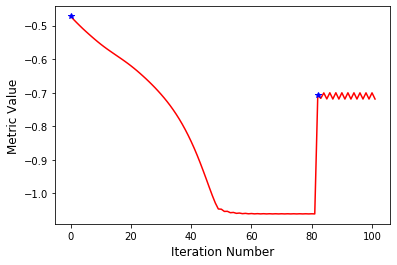

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 20.
Final metric value: -0.7001988271234335
TOF file for iCafe tracing generated!
itk::simple::AffineTransform
 AffineTransform (000002510ABE9FB0)
   RTTI typeinfo:   class itk::AffineTransform<double,3>
   Reference Count: 3
   Modified Time: 1886417577
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.00005 -0.0612077 0.0133801 
     0.0599574 0.97305 -0.227917 
     -0.000963315 0.229098 0.981932 
   Offset: [5.97871, 4.1387, -12.0513]
   Center: [89.8295, 89.8295, 41.7614]
   Translation: [1.04357, -2.41441, 7.68741]
   Inverse: 
     0.996208 0.0624478 0.000920192 
     -0.0579866 0.970809 0.226126 
     0.0145064 -0.226442 0.965643 
   Singular: 0



[[ 1.00004840e+00 -6.12077083e-02  1.33800855e-02]
 [ 5.99574311e-02  9.73049763e-01 -2.27917050e-01]
 [-9.63315262e-04  2.29097819e-01  9.81931834e-01]]
[  5.97871177   4.1386982  -12.05125121]
init se

In [13]:
# STARTS REGISTRATION AND FILE SAVING!!!

for case in caselist:
    # if case != c:continue
    if case not in info:
#         print('Case not found in Org_images, skipping...')
        continue
        
    print(case)
    
    caseinfo = info[case]
    
    if not os.path.exists(split_seq_path + case):
        print('No split dcm for',case)
        continue
    
    TP1_TOF_path = split_seq_path + case +'/S104/'+caseinfo[0]+'/'
    TP2_TOF_path = split_seq_path + case +'/S104/'+caseinfo[1]+'/'
    TP3_TOF_path = split_seq_path + case +'/S104/'+caseinfo[2]+'/'
    
    TP1_T1_path = split_seq_path + case +'/S101/'+caseinfo[0]+'/'
    TP2_T1_path = split_seq_path + case +'/S101/'+caseinfo[1]+'/'
    TP3_T1_path = split_seq_path + case +'/S101/'+caseinfo[2]+'/'
    
    TP1_CET1_path = split_seq_path + case +'/S105/'+caseinfo[0]+'/'
    TP2_CET1_path = split_seq_path + case +'/S105/'+caseinfo[1]+'/'
    TP3_CET1_path = split_seq_path + case +'/S105/'+caseinfo[2]+'/'
    
    TP1_SNAP_path = split_seq_path + case +'/S109/'+caseinfo[0]+'/'
    TP2_SNAP_path = split_seq_path + case +'/S109/'+caseinfo[1]+'/'
    TP3_SNAP_path = split_seq_path + case +'/S109/'+caseinfo[2]+'/'
    
    case_outputpath = outputpath+case+'/'
    if not os.path.exists(case_outputpath):
        os.mkdir(case_outputpath)
 
    ### register TP2/3-TOF to TP1-TOF
    moving_seq = [TP2_TOF_path, TP3_TOF_path]

    for ms in moving_seq:
        movingpath = []
        scan = ''
        
        flist = sortdir(os.listdir(ms))
        if len(flist)==0:
            print('Empty', ms)
            continue

        TP = 'E'+str(re.split('E|S|I|.dcm',flist[0])[1])
        # finalsavepath = outputpath+case+'/'+TP+'/' 
        SEQ = 'S'+str(re.split('E|S|I|.dcm',flist[0])[2])
        
        patientid = idbank[case][0]
        timepoint = str(caseinfo.index(TP)+1)
        # timepoint = str(re.split('TP|/',ms)[4])
        
        icafesavepath = icafepath+'0_'+ patientid + '-TP' + timepoint + '_U'+'/'
        if not os.path.exists(icafesavepath):
            os.mkdir(icafesavepath)

        if 'S101' in ms:
            scan = 'T1'
        elif 'S104' in ms:
            scan = 'TOF'
        elif 'S105' in ms:
            scan = 'CET1'
        elif 'S109' in ms:
            scan = 'SNAP'

        for f in flist:
            movingpath.append(ms+f)
            
        reader = sitk.ImageSeriesReader()
        print("reading image......",scan)
        moving_image = sitk.ReadImage(movingpath)
        movspa = moving_image.GetSpacing()
        print(movspa)
        sitk.WriteImage(sitk.Cast(moving_image,sitk.sitkInt16), icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U' + SEQ + '_ori.tif')
        
        fixed_image = sitk.ReadImage('E:/iCafe/result/RealmReg2020/0_' + patientid + '-TP1_U/TH_0_' + patientid + '-TP1_U.tif')
        refspa = (fixed_image.GetSpacing()[0], fixed_image.GetSpacing()[1], fixed_image.GetSpacing()[0])
        print(refspa)
        fixed_image.SetSpacing(refspa)
        moving_image = sitk.ReadImage(icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U' + SEQ + '_ori.tif')
        moving_image.SetSpacing(movspa)
        #print(moving_image.GetDimension())
        #print(fixed_image.GetDimension())
        #print("ref:",refpath[0])
        # print("mov:",movingpath[0])
        initialTx = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image,sitk.sitkFloat32), 
                                                      sitk.Cast(moving_image,sitk.sitkFloat32), 
                                                      sitk.AffineTransform(3),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)   
        registration_method = sitk.ImageRegistrationMethod()
        #registration_method.SetMetricAsCorrelation()
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=64) 
        registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
        registration_method.SetMetricSamplingPercentage(0.3)
        registration_method.SetInterpolator(sitk.sitkLinear)
        registration_method.SetOptimizerAsGradientDescent(learningRate=0.001, numberOfIterations=500,
                                                          convergenceWindowSize = 20,
                                                          estimateLearningRate=registration_method.EachIteration)
        registration_method.SetOptimizerScalesFromPhysicalShift() 
        finalTx = sitk.AffineTransform(initialTx)
        registration_method.SetInitialTransform(finalTx)
        registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [2,1])
        registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [1,0])
        registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
        registration_method.AddCommand(sitk.sitkStartEvent,metric_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent,metric_end_plot)
        registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
                                       metric_update_multires_iterations) 
        registration_method.AddCommand(sitk.sitkIterationEvent, 
                                       lambda: metric_plot_values(registration_method))
        registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                    sitk.Cast(moving_image, sitk.sitkFloat32))

        print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
        print('Final metric value: {0}'.format(registration_method.GetMetricValue()))

        resample = sitk.ResampleImageFilter()
        resample.SetReferenceImage(fixed_image)    
        resample.SetInterpolator(sitk.sitkBSpline)  
        resample.SetTransform(finalTx)
        exqimg = resample.Execute(moving_image)
        
        # modify below line to have the correct naming convention!
        
        sitk.WriteImage(sitk.Cast(exqimg,sitk.sitkInt16), icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U'+SEQ + '_reg.tif')
        
        # below is modified so an extra S104 .tif file is generated for iCafe tracing
        if SEQ == 'S104':
            sitk.WriteImage(sitk.Cast(exqimg,sitk.sitkInt16), icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U.tif')
            print('TOF file for iCafe tracing generated!')
        
        print(finalTx) 
        print('\n')
        
        # write transform xml
        c = np.array(finalTx.GetCenter())
        A = np.resize(finalTx.GetParameters()[0:9], (3,3))
        t = np.array(finalTx.GetParameters()[9:12])
        print(A)
        o = t+c-np.matmul(A, c)
        print(o)
        
        A11 = A[0,0]*refspa[0]/movspa[0]
        A12 = A[0,1]*refspa[1]/movspa[0]
        A13 = A[0,2]*refspa[2]/movspa[0]
        A21 = A[1,0]*refspa[0]/movspa[1]
        A22 = A[1,1]*refspa[1]/movspa[1]
        A23 = A[1,2]*refspa[2]/movspa[1]
        A31 = A[2,0]*refspa[0]/movspa[2]
        A32 = A[2,1]*refspa[1]/movspa[2]
        A33 = A[2,2]*refspa[2]/movspa[2]
        O1 = o[0]/movspa[0]
        O2 = o[1]/movspa[1]
        O3 = o[2]/movspa[2]
        
        icafem = iCafe(icafepath+'0_'+ patientid + '-TP' + timepoint + '_U')
        #first three rows: rotation matrix, last row: translation
        #in iCafe, the original MRA position is mapped to S10X space through rtm
        #mra_pos*rotation+translation = seq_pos
        rtm = [[A11,A12,A13],
               [A21,A22,A23],
               [A31,A32,A33],
               [O1,O2,O3]]
        icafem.xml.add_seq_rtm(SEQ,rtm)
        icafem.xml.writexml()
            
print('Operation completed!')


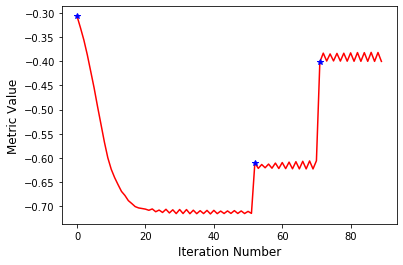

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 19.
Final metric value: -0.3818448728327032
itk::simple::AffineTransform
 AffineTransform (000002510ABE9870)
   RTTI typeinfo:   class itk::AffineTransform<double,3>
   Reference Count: 3
   Modified Time: 2510242056
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.997514 -0.0735384 0.0211169 
     0.0731807 0.999492 -0.0116592 
     -0.0270487 0.0271478 0.999846 
   Offset: [-2.48694, -9.62649, -3.75699]
   Center: [89.8295, 89.8295, 41.7614]
   Translation: [-8.43428, -3.58521, -3.7545]
   Inverse: 
     0.996525 0.0738684 -0.0201854 
     -0.072626 0.994808 0.0131344 
     0.0289308 -0.0250126 0.999251 
   Singular: 0



[[ 0.9975142  -0.07353838  0.02111694]
 [ 0.0731807   0.99949235 -0.01165924]
 [-0.02704873  0.02714781  0.99984647]]
[-2.48693672 -9.62649318 -3.75699201]
write E:\iCafe\result\RealmReg2020/0_07-08-TP3_U\setting_TH_0_07-08-TP3_U.xml


In [14]:
# STARTS REGISTRATION AND FILE SAVING!!!

for case in caselist:
    # if case != 'P680':continue
    if case not in info:
#         print('Case not found in Org_images, skipping...')
        continue
        
    print(case)
    
    caseinfo = info[case]
    
    if not os.path.exists(split_seq_path + case):
        print('No split dcm for',case)
        continue
    
    TP1_TOF_path = split_seq_path + case +'/S104/'+caseinfo[0]+'/'
    TP2_TOF_path = split_seq_path + case +'/S104/'+caseinfo[1]+'/'
    TP3_TOF_path = split_seq_path + case +'/S104/'+caseinfo[2]+'/'
    
    TP1_T1_path = split_seq_path + case +'/S101/'+caseinfo[0]+'/'
    TP2_T1_path = split_seq_path + case +'/S101/'+caseinfo[1]+'/'
    TP3_T1_path = split_seq_path + case +'/S101/'+caseinfo[2]+'/'
    
    TP1_CET1_path = split_seq_path + case +'/S105/'+caseinfo[0]+'/'
    TP2_CET1_path = split_seq_path + case +'/S105/'+caseinfo[1]+'/'
    TP3_CET1_path = split_seq_path + case +'/S105/'+caseinfo[2]+'/'
    
    TP1_SNAP_path = split_seq_path + case +'/S109/'+caseinfo[0]+'/'
    TP2_SNAP_path = split_seq_path + case +'/S109/'+caseinfo[1]+'/'
    TP3_SNAP_path = split_seq_path + case +'/S109/'+caseinfo[2]+'/'
    
    case_outputpath = outputpath+case+'/'
    if not os.path.exists(case_outputpath):
        os.mkdir(case_outputpath)
 
    ### register TP2/3-TOF to TP1-TOF
    moving_seq = [TP1_SNAP_path, TP2_SNAP_path, TP3_SNAP_path]
         
    for ms in moving_seq:
        movingpath = []
        scan = ''
        
        flist = sortdir(os.listdir(ms))
        if len(flist)==0:
            print('Empty', ms)
            continue

        TP = 'E'+str(re.split('E|S|I|.dcm',flist[0])[1])
        # finalsavepath = outputpath+case+'/'+TP+'/' 
        SEQ = 'S'+str(re.split('E|S|I|.dcm',flist[0])[2])
        
        patientid = idbank[case][0]
        timepoint = str(caseinfo.index(TP)+1)
        # timepoint = str(re.split('TP|/',ms)[4])
        
        icafesavepath = icafepath+'0_'+ patientid + '-TP' + timepoint + '_U'+'/'
        if not os.path.exists(icafesavepath):
            os.mkdir(icafesavepath)

        if 'S101' in ms:
            scan = 'T1'
        elif 'S104' in ms:
            scan = 'TOF'
        elif 'S105' in ms:
            scan = 'CET1'
        elif 'S109' in ms:
            scan = 'SNAP'

        for f in flist:
            movingpath.append(ms+f)
            
        reader = sitk.ImageSeriesReader()
        print("reading image......",scan)
        moving_image = sitk.ReadImage(movingpath)
        movspa = moving_image.GetSpacing()
        print(movspa)
        sitk.WriteImage(sitk.Cast(moving_image,sitk.sitkInt16), icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U' + SEQ + '_ori.tif')
        fixed_image = sitk.ReadImage(icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U.tif')
        refspa = (fixed_image.GetSpacing()[0], fixed_image.GetSpacing()[1], fixed_image.GetSpacing()[0])
        print(refspa)
        fixed_image.SetSpacing(refspa)
        moving_image = sitk.ReadImage(icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U' + SEQ + '_ori.tif')
        moving_image.SetSpacing(movspa)
        #print(moving_image.GetDimension())
        #print(fixed_image.GetDimension())
        #print("ref:",refpath[0])
        # print("mov:",movingpath[0])
        initialTx = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image,sitk.sitkFloat32), 
                                                      sitk.Cast(moving_image,sitk.sitkFloat32), 
                                                      sitk.AffineTransform(3),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)   
        registration_method = sitk.ImageRegistrationMethod()
        #registration_method.SetMetricAsCorrelation()
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=256) 
        registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
        registration_method.SetMetricSamplingPercentage(0.3)
        registration_method.SetInterpolator(sitk.sitkLinear)
        registration_method.SetOptimizerAsGradientDescent(learningRate=0.001, numberOfIterations=500,
                                                          convergenceWindowSize = 20,
                                                          estimateLearningRate=registration_method.EachIteration)
        registration_method.SetOptimizerScalesFromPhysicalShift() 
        finalTx = sitk.AffineTransform(initialTx)
        registration_method.SetInitialTransform(finalTx)
        registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
        registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
        registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
        registration_method.AddCommand(sitk.sitkStartEvent,metric_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent,metric_end_plot)
        registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
                                       metric_update_multires_iterations) 
        registration_method.AddCommand(sitk.sitkIterationEvent, 
                                       lambda: metric_plot_values(registration_method))
        registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                    sitk.Cast(moving_image, sitk.sitkFloat32))

        print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
        print('Final metric value: {0}'.format(registration_method.GetMetricValue()))

        resample = sitk.ResampleImageFilter()
        resample.SetReferenceImage(fixed_image)    
        resample.SetInterpolator(sitk.sitkBSpline)  
        resample.SetTransform(finalTx)
        exqimg = resample.Execute(moving_image)
        
        # modify below line to have the correct naming convention!
        
        sitk.WriteImage(sitk.Cast(exqimg,sitk.sitkInt16), icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U'+SEQ + '_reg.tif')
        
        # below is modified so an extra S104 .tif file is generated for iCafe tracing
        if SEQ == 'S104':
            sitk.WriteImage(sitk.Cast(exqimg,sitk.sitkInt16), icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U.tif')
            print('TOF file for iCafe tracing generated!')
        
        print(finalTx) 
        print('\n')
        
        # write transform xml
        c = np.array(finalTx.GetCenter())
        A = np.resize(finalTx.GetParameters()[0:9], (3,3))
        t = np.array(finalTx.GetParameters()[9:12])
        print(A)
        o = t+c-np.matmul(A, c)
        print(o)
        
        A11 = A[0,0]*refspa[0]/movspa[0]
        A12 = A[0,1]*refspa[1]/movspa[0]
        A13 = A[0,2]*refspa[2]/movspa[0]
        A21 = A[1,0]*refspa[0]/movspa[1]
        A22 = A[1,1]*refspa[1]/movspa[1]
        A23 = A[1,2]*refspa[2]/movspa[1]
        A31 = A[2,0]*refspa[0]/movspa[2]
        A32 = A[2,1]*refspa[1]/movspa[2]
        A33 = A[2,2]*refspa[2]/movspa[2]
        O1 = o[0]/movspa[0]
        O2 = o[1]/movspa[1]
        O3 = o[2]/movspa[2]
        
        icafem = iCafe(icafepath+'0_'+ patientid + '-TP' + timepoint + '_U')
        #first three rows: rotation matrix, last row: translation
        #in iCafe, the original MRA position is mapped to S10X space through rtm
        #mra_pos*rotation+translation = seq_pos
        rtm = [[A11,A12,A13],
               [A21,A22,A23],
               [A31,A32,A33],
               [O1,O2,O3]]
        icafem.xml.add_seq_rtm(SEQ,rtm)
        icafem.xml.writexml()
            
print('Operation completed!')


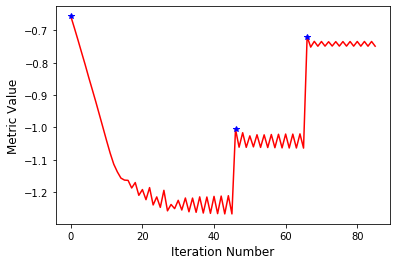

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 20.
Final metric value: -0.7342419046092178
itk::simple::AffineTransform
 AffineTransform (000002511FCAA9E0)
   RTTI typeinfo:   class itk::AffineTransform<double,3>
   Reference Count: 2
   Modified Time: 3489034951
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.995703 0.0675296 -0.0182232 
     -0.0642257 0.996293 0.0192867 
     0.0205639 -0.0300141 0.98699 
   Offset: [-17.0972, -9.55367, 13.4779]
   Center: [99.8512, 99.8512, 19.8025]
   Translation: [-11.1442, -15.9549, 12.2766]
   Inverse: 
     0.999575 -0.0671566 0.0197679 
     0.0648023 0.998777 -0.0183205 
     -0.0188555 0.0317718 1.01221 
   Singular: 0



[[ 0.99957531 -0.0671566   0.01976789]
 [ 0.06480233  0.99877662 -0.01832054]
 [-0.01885547  0.03177178  1.0122125 ]]
[ 16.18191697  10.89684672 -13.66130682]
write E:\iCafe\result\RealmReg2020/0_07-08-TP3_U\setting_TH_0_07-08-TP3_U.xml

In [15]:
# STARTS REGISTRATION AND FILE SAVING!!!

for case in caselist:
    # if case != 'P680':continue
    if case not in info:
#         print('Case not found in Org_images, skipping...')
        continue
        
    print(case)
    
    caseinfo = info[case]
    
    if not os.path.exists(split_seq_path + case):
        print('No split dcm for',case)
        continue
    
    TP1_TOF_path = split_seq_path + case +'/S104/'+caseinfo[0]+'/'
    TP2_TOF_path = split_seq_path + case +'/S104/'+caseinfo[1]+'/'
    TP3_TOF_path = split_seq_path + case +'/S104/'+caseinfo[2]+'/'
    
    TP1_T1_path = split_seq_path + case +'/S101/'+caseinfo[0]+'/'
    TP2_T1_path = split_seq_path + case +'/S101/'+caseinfo[1]+'/'
    TP3_T1_path = split_seq_path + case +'/S101/'+caseinfo[2]+'/'
    
    TP1_CET1_path = split_seq_path + case +'/S105/'+caseinfo[0]+'/'
    TP2_CET1_path = split_seq_path + case +'/S105/'+caseinfo[1]+'/'
    TP3_CET1_path = split_seq_path + case +'/S105/'+caseinfo[2]+'/'
    
    TP1_SNAP_path = split_seq_path + case +'/S109/'+caseinfo[0]+'/'
    TP2_SNAP_path = split_seq_path + case +'/S109/'+caseinfo[1]+'/'
    TP3_SNAP_path = split_seq_path + case +'/S109/'+caseinfo[2]+'/'
    
    case_outputpath = outputpath+case+'/'
    if not os.path.exists(case_outputpath):
        os.mkdir(case_outputpath)
 
    ### register TP2/3-TOF to TP1-TOF
    moving_seq = [TP1_T1_path, TP1_CET1_path, TP2_T1_path, TP2_CET1_path, TP3_T1_path, TP3_CET1_path]

    for ms in moving_seq: 
        movingpath = []
        scan = ''
        
        flist = sortdir(os.listdir(ms))
        if len(flist)==0:
            print('Empty', ms)
            continue

        TP = 'E'+str(re.split('E|S|I|.dcm',flist[0])[1])
        # finalsavepath = outputpath+case+'/'+TP+'/' 
        SEQ = 'S'+str(re.split('E|S|I|.dcm',flist[0])[2])
        
        patientid = idbank[case][0]
        timepoint = str(caseinfo.index(TP)+1)
        # timepoint = str(re.split('TP|/',ms)[4])
        
        icafesavepath = icafepath+'0_'+ patientid + '-TP' + timepoint + '_U'+'/'
        if not os.path.exists(icafesavepath):
            os.mkdir(icafesavepath)

        if 'S101' in ms:
            scan = 'T1'
        elif 'S104' in ms:
            scan = 'TOF'
        elif 'S105' in ms:
            scan = 'CET1'
        elif 'S109' in ms:
            scan = 'SNAP'

        for f in flist:
            movingpath.append(ms+f)
            
        reader = sitk.ImageSeriesReader()
        print("reading image......",scan)
        moving_image = sitk.ReadImage(movingpath)
        movspa = moving_image.GetSpacing()
        print(movspa)
        sitk.WriteImage(sitk.Cast(moving_image,sitk.sitkInt16), icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U' + SEQ + '_ori.tif')
        fixed_image = sitk.ReadImage(icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U.tif')
        refspa = (fixed_image.GetSpacing()[0], fixed_image.GetSpacing()[1], fixed_image.GetSpacing()[0])
        print(refspa)
        fixed_image.SetSpacing(refspa)
        moving_image = sitk.ReadImage(icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U' + SEQ + '_ori.tif')
        moving_image.SetSpacing(movspa)
        #print(moving_image.GetDimension())
        #print(fixed_image.GetDimension())
        #print("ref:",refpath[0])
        # print("mov:",movingpath[0])
        
        # swap fixed and moving for T1 and CET1
        tmp = fixed_image
        fixed_image = moving_image
        moving_image = tmp
        
        initialTx = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image,sitk.sitkFloat32), 
                                                      sitk.Cast(moving_image,sitk.sitkFloat32), 
                                                      sitk.AffineTransform(3),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)   
        registration_method = sitk.ImageRegistrationMethod()
        #registration_method.SetMetricAsCorrelation()
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=256) 
        registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
        registration_method.SetMetricSamplingPercentage(0.3)
        registration_method.SetInterpolator(sitk.sitkLinear)
        registration_method.SetOptimizerAsGradientDescent(learningRate=0.001, numberOfIterations=500,
                                                          convergenceWindowSize = 20,
                                                          estimateLearningRate=registration_method.EachIteration)
        registration_method.SetOptimizerScalesFromPhysicalShift() 
        finalTx = sitk.AffineTransform(initialTx)
        registration_method.SetInitialTransform(finalTx)
        registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
        registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
        registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
        registration_method.AddCommand(sitk.sitkStartEvent,metric_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent,metric_end_plot)
        registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
                                       metric_update_multires_iterations) 
        registration_method.AddCommand(sitk.sitkIterationEvent, 
                                       lambda: metric_plot_values(registration_method))
        registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                    sitk.Cast(moving_image, sitk.sitkFloat32))

        print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
        print('Final metric value: {0}'.format(registration_method.GetMetricValue()))

        resample = sitk.ResampleImageFilter()
        # resample.SetReferenceImage(fixed_image)
        resample.SetReferenceImage(moving_image)
        resample.SetInterpolator(sitk.sitkBSpline)  
        #resample.SetTransform(finalTx)
        #exqimg = resample.Execute(moving_image)
        resample.SetTransform(finalTx.GetInverse())
        exqimg = resample.Execute(fixed_image)
        
        # modify below line to have the correct naming convention!
        
        sitk.WriteImage(sitk.Cast(exqimg,sitk.sitkInt16), icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U'+SEQ + '_reg.tif')
        
        # below is modified so an extra S104 .tif file is generated for iCafe tracing
        if SEQ == 'S104':
            sitk.WriteImage(sitk.Cast(exqimg,sitk.sitkInt16), icafesavepath + 'TH_0_'+ patientid + '-TP' + timepoint + '_U.tif')
            print('TOF file for iCafe tracing generated!')
        
        print(finalTx) 
        print('\n')
        
        # write transform xml
        c = np.array(finalTx.GetCenter())
        A = np.resize(finalTx.GetInverse().GetParameters()[0:9], (3,3))
        t = np.array(finalTx.GetInverse().GetParameters()[9:12])
        print(A)
        o = t+c-np.matmul(A, c)
        print(o)
        
        A11 = A[0,0]*refspa[0]/movspa[0]
        A12 = A[0,1]*refspa[1]/movspa[0]
        A13 = A[0,2]*refspa[2]/movspa[0]
        A21 = A[1,0]*refspa[0]/movspa[1]
        A22 = A[1,1]*refspa[1]/movspa[1]
        A23 = A[1,2]*refspa[2]/movspa[1]
        A31 = A[2,0]*refspa[0]/movspa[2]
        A32 = A[2,1]*refspa[1]/movspa[2]
        A33 = A[2,2]*refspa[2]/movspa[2]
        O1 = o[0]/movspa[0]
        O2 = o[1]/movspa[1]
        O3 = o[2]/movspa[2]
        
        icafem = iCafe(icafepath+'0_'+ patientid + '-TP' + timepoint + '_U')
        #first three rows: rotation matrix, last row: translation
        #in iCafe, the original MRA position is mapped to S10X space through rtm
        #mra_pos*rotation+translation = seq_pos
        rtm = [[A11,A12,A13],
               [A21,A22,A23],
               [A31,A32,A33],
               [O1,O2,O3]]
        icafem.xml.add_seq_rtm(SEQ,rtm)
        icafem.xml.writexml()
            
print('Operation completed!')
